In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
import json
import requests
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import string
import mapclassify
from shapely.ops import unary_union
plt.style.use('ggplot')


# Opening GeoJSONs and exploring data

### Zoning data

In [2]:
zones_geodata = gpd.read_file('CME538_Daniel_Group_Zoning Area - 4326.geojson')
zones_geodata = zones_geodata.set_index(zones_geodata.columns[0])
zones_geodata.head()

GEN_ZONE ZN_ZONE ZN_HOLDING  HOLDING_ID  FRONTAGE  ZN_AREA  UNITS  \
_id                                                                      
1           2      UT          N           0      -1.0       -1     -1   
2           1      ON          N           0      -1.0       -1     -1   
3           0      RD          N           0      14.0      510      0   
4           1       O          N           0      -1.0       -1     -1   
5           0      RD          N           0       0.0        0      0   

     DENSITY  COVERAGE  FSI_TOTAL  ...  ZN_EXCPTN  EXCPTN_NO  STAND_SET  \
_id                                ...                                    
1       -1.0       0.0       -1.0  ...          N          0         -1   
2       -1.0       0.0       -1.0  ...          N          0         -1   
3        0.0       0.0       -1.0  ...          Y       1058         -1   
4       -1.0       0.0       -1.0  ...          N          0         -1   
5        0.0       0.0       -1.0  ...          Y       1040         -1   

     ZN_STATUS                 ZN_STRING  AREA_UNITS  ZBL_CHAPT  ZBL_SECTN  \
_id                                                                          
1            2                        UT        -1.0        100     100.10   
2            0                        ON        -1.0         90      90.20   
3            2  RD (f14.0; a510) (x1058)         0.0         10      10.20   
4            3                         O        -1.0         90      90.10   
5            2                RD (x1040)         0.0         10      10.20   

         ZBL_EXCPTN                                           geometry  
_id                                                                     
1                    MULTIPOLYGON (((-79.2097 43.81729, -79.20961 4...  
2                    MULTIPOLYGON (((-79.50273 43.70976, -79.50195 ...  
3    900.3.10(1058)  MULTIPOLYGON (((-79.27433 43.80068, -79.27425 ...  
4                    MULTIPOLYGON (((-79.5704 43.72175, -79.57042 4...  
5    900.3.10(1040)  MULTIPOLYGON (((-79.26202 43.81195, -79.26214 ...  

[5 rows x 24 columns]

From the description of data: 

**ZN_ZONE**

The land use category of the lands within the zone boundary. Each 'zone category' has its own Chapter in the text of By-law 569-2013. Zoned destination of the zone limited by GEN_ZONE. 
- 0 = Residential 
- 1 = Open Space 
- 2 = Utility and Transportation 
- 4 = Employment Industrial 
- 5 = Institutional 
- 6 = Commercial Residential Employment 
- 101 = Residential Apartment 
- 201 = Commercial 
- 202 = Commercial Residential

In [3]:
zones_geodata.GEN_ZONE.unique()

array([  2,   1,   0,   4, 201, 202, 101,   6,   5])

In [4]:
# Only keep zoning type, and geometry, rest is not relevant
zones_geodata_cleaned = zones_geodata[['GEN_ZONE', 'geometry']]

# Rename 'GEN_ZONE' to 'Zone_type'
zones_geodata_cleaned.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)

# Define the mapping for Zone Type values
zone_mapping = {0: 'Residential', 1: 'Open Space', 2: 'Utility and Transportation', 
                4: 'Employment Industrial', 5: 'Institutional',
                6: 'Commercial Residential Employment', 101: 'Residential Apartment', 
                201: 'Commercial', 202: 'Commercial Residential'}

# Replace the values in 'Zone_type' column with the mapped names
zones_geodata_cleaned['Zone_type'] = zones_geodata_cleaned['Zone_type'].replace(zone_mapping)

# Display the first few rows to ensure it worked
zones_geodata_cleaned.head()


C:\Users\aaron\AppData\Local\Temp\ipykernel_27220\1307462323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zones_geodata_cleaned.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)
c:\Users\aaron\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Zone_type  \
_id                               
1    Utility and Transportation   
2                    Open Space   
3                   Residential   
4                    Open Space   
5                   Residential   

                                              geometry  
_id                                                     
1    MULTIPOLYGON (((-79.2097 43.81729, -79.20961 4...  
2    MULTIPOLYGON (((-79.50273 43.70976, -79.50195 ...  
3    MULTIPOLYGON (((-79.27433 43.80068, -79.27425 ...  
4    MULTIPOLYGON (((-79.5704 43.72175, -79.57042 4...  
5    MULTIPOLYGON (((-79.26202 43.81195, -79.26214 ...

In [5]:
zones_geodata_cleaned.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

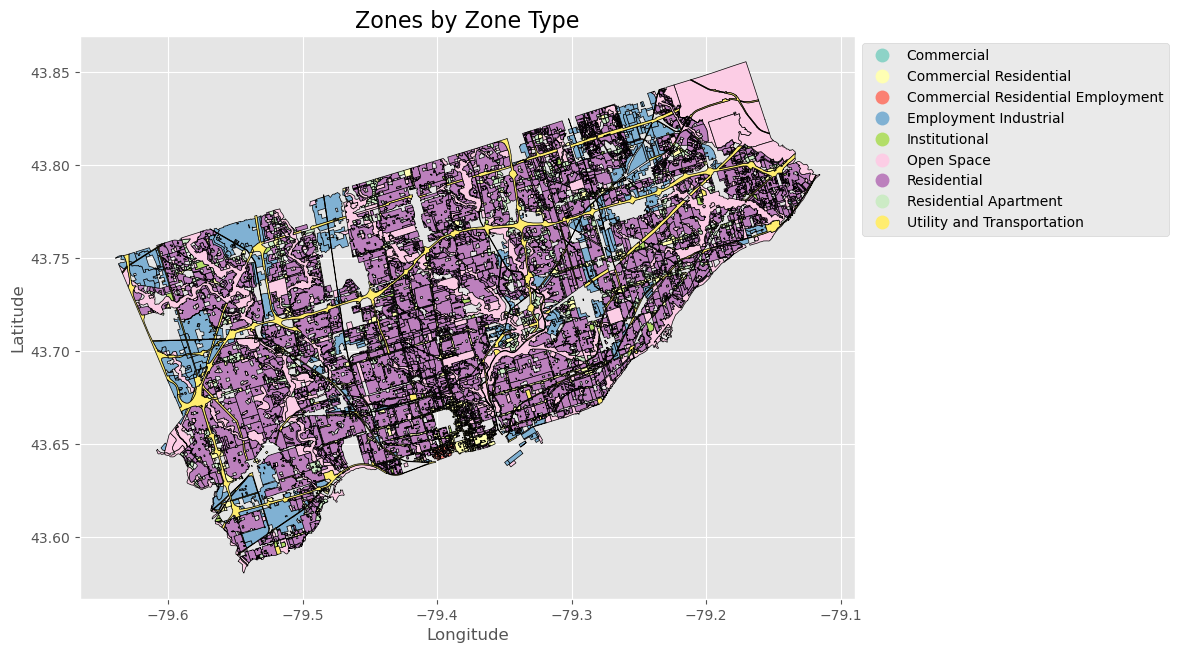

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with categorical coloring based on 'Zone_type'
zones_geodata_cleaned.plot(column='Zone_type', ax=ax, legend=True, 
                           legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                           cmap='Set3', edgecolor='black')

# Add labels
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Zones by Zone Type', fontsize=16)

# Display the plot
plt.show()

c:\Users\aaron\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


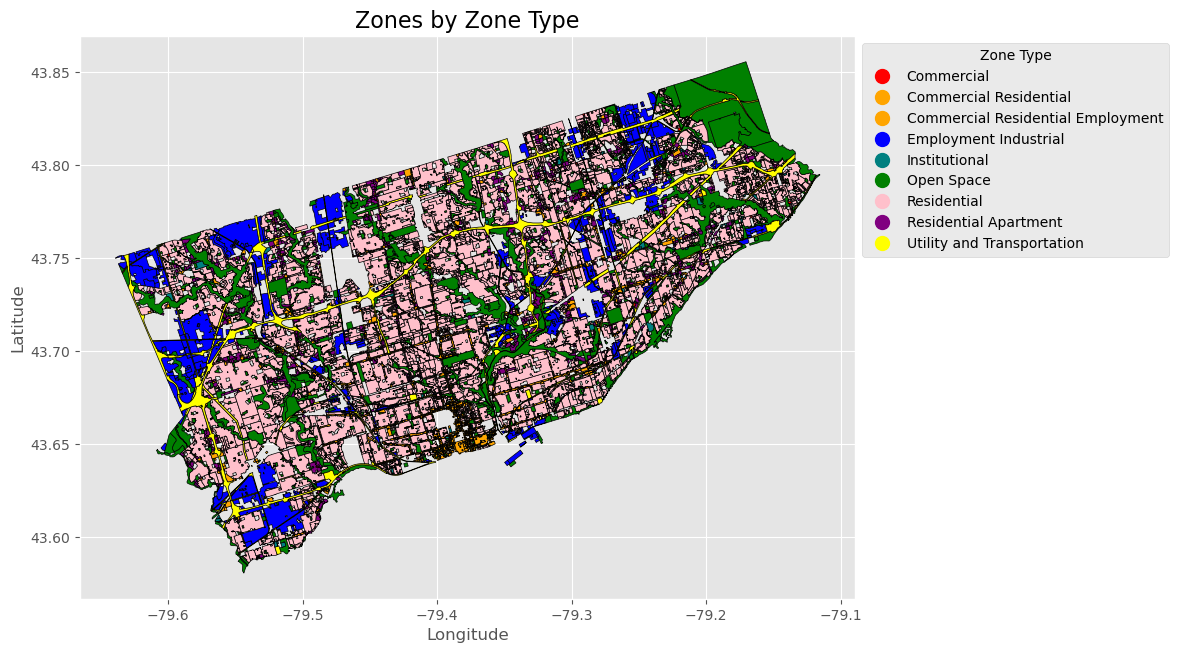

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a dictionary for the specific colors for each Zone_type
custom_colors = {
    'Commercial': 'red',
    'Commercial Residential': 'orange',
    'Commercial Residential Employment': 'orange',
    'Employment Industrial': 'blue',
    'Institutional': 'teal',
    'Open Space': 'green',
    'Residential': 'pink',
    'Residential Apartment': 'purple',
    'Utility and Transportation': 'yellow'
}

# Map Zone_type to colors
zones_geodata_cleaned['color'] = zones_geodata_cleaned['Zone_type'].map(custom_colors)

# Create a custom legend manually
legend_labels = list(custom_colors.keys())
legend_colors = [custom_colors[label] for label in legend_labels]

# Plot with the custom colors
fig, ax = plt.subplots(figsize=(10, 8))
zones_geodata_cleaned.plot(color=zones_geodata_cleaned['color'], ax=ax, edgecolor='black')

# Add custom legend
handles = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10, linestyle='') 
           for label, color in zip(legend_labels, legend_colors)]
ax.legend(handles=handles, title='Zone Type', bbox_to_anchor=(1, 1), loc='upper left')

# Add labels and title
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Zones by Zone Type', fontsize=16)

# Display the plot
plt.show()


### Greenspace data

In [8]:
greenspace = gpd.read_file('Green Spaces - 4326.geojson')
greenspace = greenspace.set_index(greenspace.columns[0])
greenspace.head()

AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_CLASS_ID      AREA_CLASS  \
_id                                                                         
1          1             1               0          890.0  OTHER_CEMETERY   
2          2             2               0          890.0  OTHER_CEMETERY   
3          3             3               0          890.0  OTHER_CEMETERY   
4          4             4               0          890.0  OTHER_CEMETERY   
5          5             5               0          890.0  OTHER_CEMETERY   

    AREA_SHORT_CODE AREA_LONG_CODE                            AREA_NAME  \
_id                                                                       
1              None           4009     ARMADALE FREE METHODIST CEMETERY   
2              None           4010                    HILLSIDE CEMETERY   
3              None           4011              HIGHLAND MEMORY GARDENS   
4              None           4005        CHRISTIE'S METHODIST CEMETERY   
5              None           4012  ST. PAUL'S ANGLICAN CHURCH CEMETERY   

                               AREA_DESC  OBJECTID  \
_id                                                  
1       ARMADALE FREE METHODIST CEMETERY       1.0   
2                      HILLSIDE CEMETERY       2.0   
3                HIGHLAND MEMORY GARDENS       3.0   
4          CHRISTIE'S METHODIST CEMETERY       4.0   
5    ST. PAUL'S ANGLICAN CHURCH CEMETERY       5.0   

                                              geometry  
_id                                                     
1    MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ...  
2    MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ...  
3    MULTIPOLYGON (((-79.34758 43.8081, -79.34758 4...  
4    MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ...  
5    MULTIPOLYGON (((-79.31649 43.7964, -79.3165 43...

In [9]:
greenspace.columns.unique()

Index(['AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_CLASS_ID',
       'AREA_CLASS', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME',
       'AREA_DESC', 'OBJECTID', 'geometry'],
      dtype='object')

In [10]:
greenspace_cleaned = greenspace[['AREA_CLASS', 'geometry']]
greenspace_cleaned.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)
greenspace_cleaned.head()


C:\Users\aaron\AppData\Local\Temp\ipykernel_27220\3715004460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greenspace_cleaned.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)


Area_type                                           geometry
_id                                                                   
1    OTHER_CEMETERY  MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ...
2    OTHER_CEMETERY  MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ...
3    OTHER_CEMETERY  MULTIPOLYGON (((-79.34758 43.8081, -79.34758 4...
4    OTHER_CEMETERY  MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ...
5    OTHER_CEMETERY  MULTIPOLYGON (((-79.31649 43.7964, -79.3165 43...

In [11]:
greenspace_cleaned.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

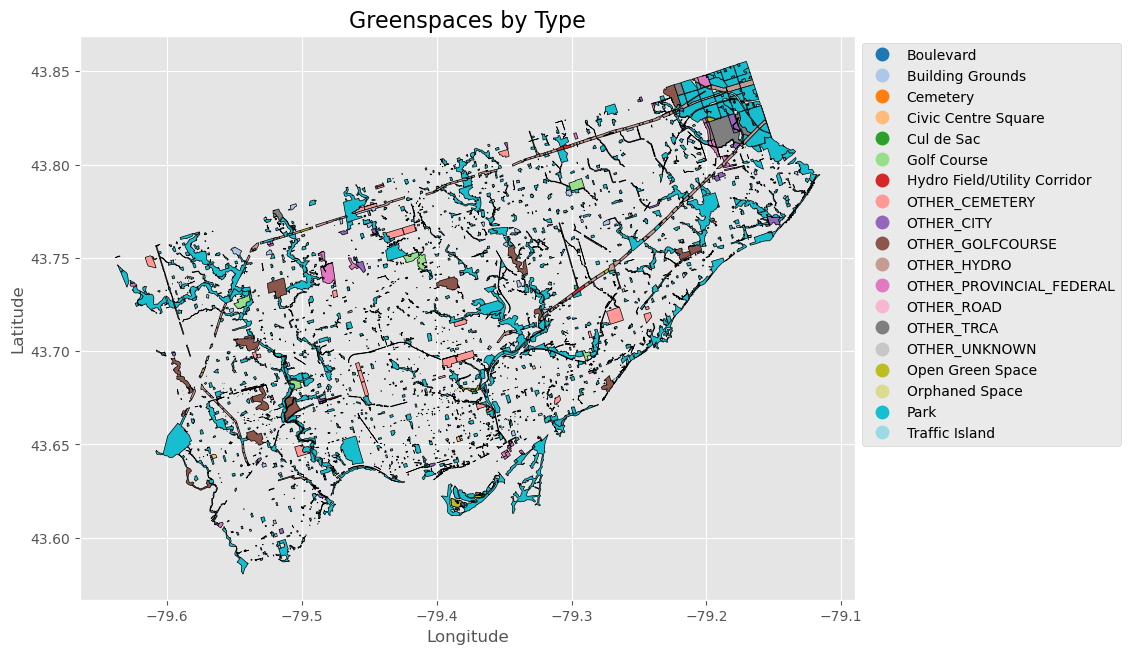

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with categorical coloring based on 'Zone_type'
greenspace_cleaned.plot(column='Area_type', ax=ax, legend=True, 
                           legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                           cmap='tab20', edgecolor='black')

# Add labels
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Greenspaces by Type', fontsize=16)

# Display the plot
plt.show()

### Flood plains data

In [13]:
flood_plains = gpd.read_file('Floodline GeoJson Format.geojson')
flood_plains = flood_plains.set_index(flood_plains.columns[0])
flood_plains.head()


FloodPlain     Watershed    Shape__Are   Shape__Len  \
OBJECTID                                                        
3394      Engineered     Don River      0.940918     3.803569   
3395      Engineered     Don River    869.856689   149.201240   
3396      Engineered     Don River  23187.910400  1321.226703   
3397      Engineered     Don River  10895.613037   522.001575   
3406      Engineered  Humber River      0.544922     5.605709   

                                                   geometry  
OBJECTID                                                     
3394      MULTIPOLYGON (((-79.36482 43.67112, -79.36482 ...  
3395      MULTIPOLYGON (((-79.38004 43.67332, -79.38004 ...  
3396      MULTIPOLYGON (((-79.37672 43.6735, -79.37671 4...  
3397      MULTIPOLYGON (((-79.3784 43.67362, -79.3784 43...  
3406      MULTIPOLYGON (((-79.5036 43.71073, -79.5036 43...

In [14]:
flood_plains.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

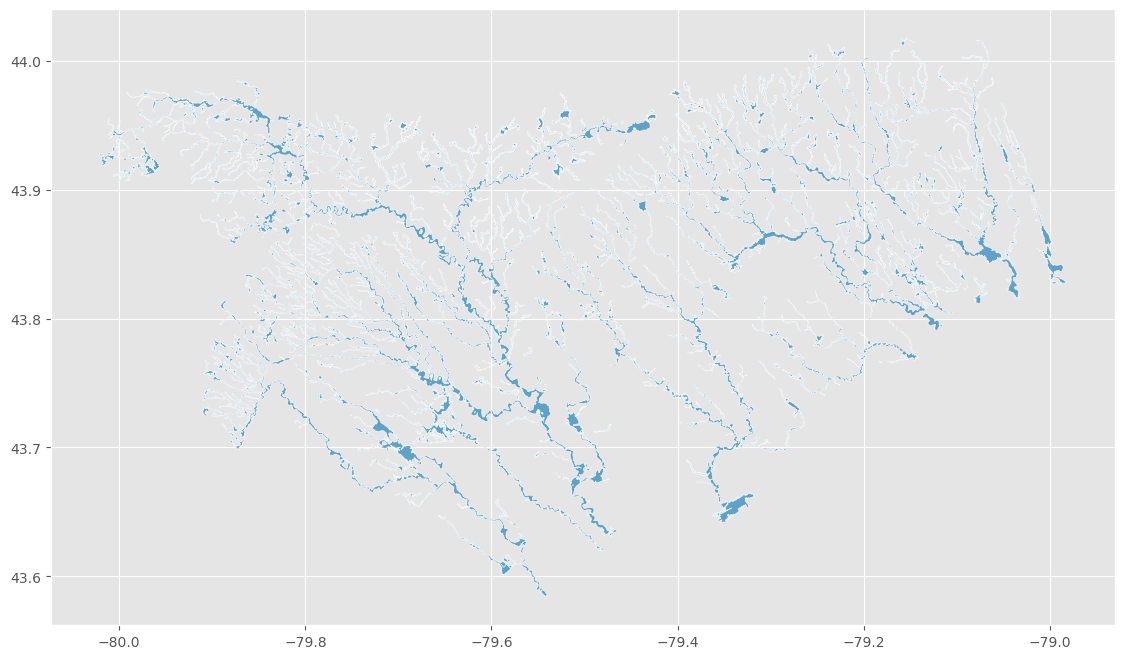

In [15]:
# Test plotting
flood_plains.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

### Neighbourhood data

In [16]:
neighbourhoods_geodata = gpd.read_file('Neighbourhoods - 4326.geojson')
neighbourhoods_geodata.head()

_id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0    1  2502366      26022881               0             174            174   
1    2  2502365      26022880               0             173            173   
2    3  2502364      26022879               0             172            172   
3    4  2502363      26022878               0             171            171   
4    5  2502362      26022877               0             170            170   

                   AREA_NAME                        AREA_DESC  \
0  South Eglinton-Davisville  South Eglinton-Davisville (174)   
1              North Toronto              North Toronto (173)   
2         Dovercourt Village         Dovercourt Village (172)   
3   Junction-Wallace Emerson   Junction-Wallace Emerson (171)   
4         Yonge-Bay Corridor         Yonge-Bay Corridor (170)   

                         CLASSIFICATION CLASSIFICATION_CODE    OBJECTID  \
0  Not an NIA or Emerging Neighbourhood                  NA  17824737.0   
1  Not an NIA or Emerging Neighbourhood                  NA  17824753.0   
2  Not an NIA or Emerging Neighbourhood                  NA  17824769.0   
3  Not an NIA or Emerging Neighbourhood                  NA  17824785.0   
4  Not an NIA or Emerging Neighbourhood                  NA  17824801.0   

                                            geometry  
0  MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...  
1  MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...  
2  MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...  
3  MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...  
4  MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...

In [17]:
keep_columns = ['AREA_NAME', 'geometry']                                                #define columns to keep
neighbourhoods_geodata = neighbourhoods_geodata.filter(items=keep_columns)                            #filter df by columns
neighbourhoods_geodata.columns = ['Neighbourhood Name', 'geometry']                                         #rename columns
neighbourhoods_geodata = neighbourhoods_geodata.set_index(neighbourhoods_geodata.columns[0])

# View GeoDataFrame
neighbourhoods_geodata.head()

geometry
Neighbourhood Name                                                          
South Eglinton-Davisville  MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...
North Toronto              MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...
Dovercourt Village         MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...
Junction-Wallace Emerson   MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...
Yonge-Bay Corridor         MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...

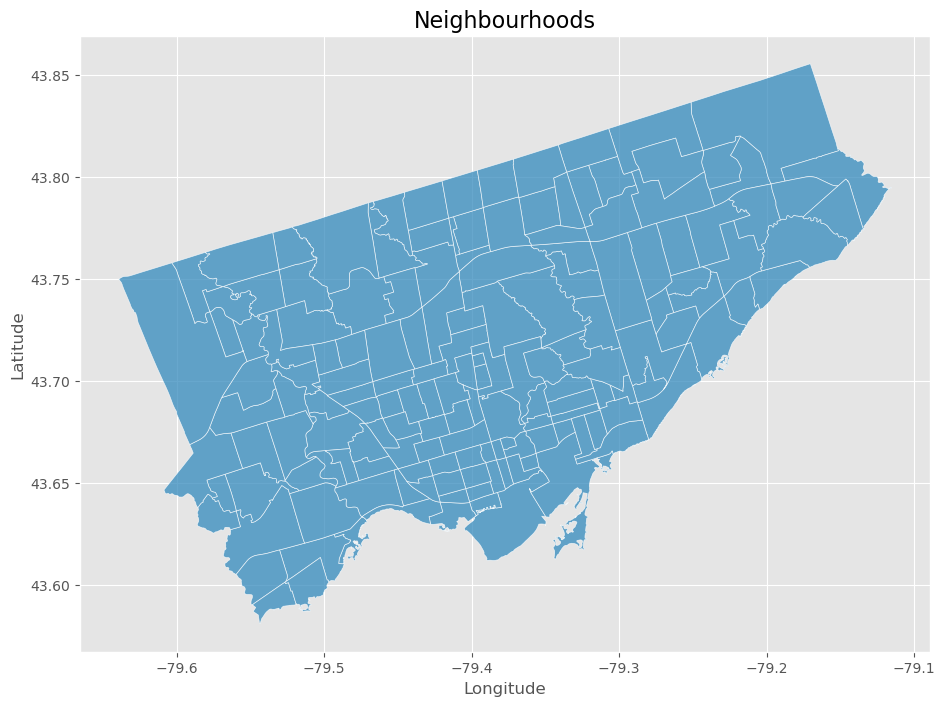

In [18]:
neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Neighbourhoods', fontsize=16)

# Display the plot
plt.show()

### Demographics Data

In [19]:
# Read the .xlsx file into a pandas DataFrame
neighbourhood_demographics = pd.read_excel("neighbourhood-profiles-2021-158-model.xlsx", engine="openpyxl")

# Print the DataFrame
neighbourhood_demographics.head()

Neighbourhood Name  \
0                               Neighbourhood Number   
1                              TSNS 2020 Designation   
2  Total - Age groups of the population - 25% sam...   
3                                      0 to 14 years   
4                                       0 to 4 years   

                 West Humber-Clairville Mount Olive-Silverstone-Jamestown  \
0                                     1                                 2   
1  Not an NIA or Emerging Neighbourhood    Neighbourhood Improvement Area   
2                                 33300                             31345   
3                                  4295                              5690   
4                                  1460                              1650   

     Thistletown-Beaumond Heights                       Rexdale-Kipling  \
0                               3                                     4   
1  Neighbourhood Improvement Area  Not an NIA or Emerging Neighbourhood   
2                            9850                                 10375   
3                            1495                                  1575   
4                             505                                   505   

                 Elms-Old Rexdale   Kingsview Village-The Westway  \
0                               5                               6   
1  Neighbourhood Improvement Area  Neighbourhood Improvement Area   
2                            9355                           22005   
3                            1610                            3915   
4                             440                            1245   

       Willowridge-Martingrove-Richview Humber Heights-Westmount  \
0                                     7                        8   
1  Not an NIA or Emerging Neighbourhood   Emerging Neighbourhood   
2                                 22445                    10005   
3                                  3500                     1370   
4                                  1065                      395   

               Edenbridge-Humber Valley  ...  \
0                                     9  ...   
1  Not an NIA or Emerging Neighbourhood  ...   
2                                 15190  ...   
3                                  2070  ...   
4                                   520  ...   

                 Harbourfront-CityPlace St Lawrence-East Bayfront-The Islands  \
0                                   165                                   166   
1  Not an NIA or Emerging Neighbourhood  Not an NIA or Emerging Neighbourhood   
2                                 28135                                 31285   
3                                  2065                                  2285   
4                                  1030                                  1045   

                       Church-Wellesley                   Downtown Yonge East  \
0                                   167                                   168   
1  Not an NIA or Emerging Neighbourhood  Not an NIA or Emerging Neighbourhood   
2                                 22320                                 17700   
3                                   895                                  1055   
4                                   495                                   480   

                         Bay-Cloverhill                    Yonge-Bay Corridor  \
0                                   169                                   170   
1  Not an NIA or Emerging Neighbourhood  Not an NIA or Emerging Neighbourhood   
2                                 16670                                 12645   
3                                   745                                   970   
4                                   370                                   500   

               Junction-Wallace Emerson                    Dovercourt Village  \
0                                   171                                   172   
1  Not an NIA or Emerging Neighbourhood  Not an

In [20]:
neighbourhood_demographics = neighbourhood_demographics.set_index(neighbourhood_demographics.columns[0])
neighbourhood_demographics.head()

West Humber-Clairville  \
Neighbourhood Name                                                                         
Neighbourhood Number                                                                   1   
TSNS 2020 Designation                               Not an NIA or Emerging Neighbourhood   
Total - Age groups of the population - 25% samp...                                 33300   
  0 to 14 years                                                                     4295   
    0 to 4 years                                                                    1460   

                                                   Mount Olive-Silverstone-Jamestown  \
Neighbourhood Name                                                                     
Neighbourhood Number                                                               2   
TSNS 2020 Designation                                 Neighbourhood Improvement Area   
Total - Age groups of the population - 25% samp...                             31345   
  0 to 14 years                                                                 5690   
    0 to 4 years                                                                1650   

                                                      Thistletown-Beaumond Heights  \
Neighbourhood Name                                                                   
Neighbourhood Number                                                             3   
TSNS 2020 Designation                               Neighbourhood Improvement Area   
Total - Age groups of the population - 25% samp...                            9850   
  0 to 14 years                                                               1495   
    0 to 4 years                                                               505   

                                                                         Rexdale-Kipling  \
Neighbourhood Name                                                                         
Neighbourhood Number                                                                   4   
TSNS 2020 Designation                               Not an NIA or Emerging Neighbourhood   
Total - Age groups of the population - 25% samp...                                 10375   
  0 to 14 years                                                                     1575   
    0 to 4 years                                                                     505   

                                                                  Elms-Old Rexdale  \
Neighbourhood Name                                                                   
Neighbourhood Number                                                             5   
TSNS 2020 Designation                               Neighbourhood Improvement Area   
Total - Age groups of the population - 25% samp...                            9355   
  0 to 14 years                                                               1610   
    0 to 4 years                                                               440   

                                                     Kingsview Village-The Westway  \
Neighbourhood Name                                                                   
Neighbourhood Number                                                             6   
TSNS 2020 Designation                               Neighbourhood Improvement Area   
Total - Age groups of the population - 25% samp...                           22005   
  0 to 14 years                                                               3915   
    0 to 4 years                                                              1245   

                                                        Willowridge-Martingrove-Richview  \
Neighbourhood Name                                                                         
Neighbourhood Number                                                                   7   
TSNS 2020 Designation                               Not an NIA or Emerging

In [21]:
len(neighbourhood_demographics.columns.tolist())


158

In [22]:
with pd.option_context('display.max_rows', 1300):
    print(neighbourhood_demographics.head(2000))

                                                                  West Humber-Clairville  \
Neighbourhood Name                                                                         
Neighbourhood Number                                                                   1   
TSNS 2020 Designation                               Not an NIA or Emerging Neighbourhood   
Total - Age groups of the population - 25% samp...                                 33300   
  0 to 14 years                                                                     4295   
    0 to 4 years                                                                    1460   
...                                                                                  ...   
      Earned doctorate                                                               130   
Total - Major field of study - Classification o...                                 29000   
  No postsecondary certificate, diploma or degree                               

In [23]:
neighbourhood_demographics_transpose = neighbourhood_demographics.T
neighbourhood_demographics_transpose.head()

Neighbourhood Name                Neighbourhood Number  \
West Humber-Clairville                               1   
Mount Olive-Silverstone-Jamestown                    2   
Thistletown-Beaumond Heights                         3   
Rexdale-Kipling                                      4   
Elms-Old Rexdale                                     5   

Neighbourhood Name                                TSNS 2020 Designation  \
West Humber-Clairville             Not an NIA or Emerging Neighbourhood   
Mount Olive-Silverstone-Jamestown        Neighbourhood Improvement Area   
Thistletown-Beaumond Heights             Neighbourhood Improvement Area   
Rexdale-Kipling                    Not an NIA or Emerging Neighbourhood   
Elms-Old Rexdale                         Neighbourhood Improvement Area   

Neighbourhood Name                Total - Age groups of the population - 25% sample data  \
West Humber-Clairville                                                         33300       
Mount Olive-Silverstone-Jamestown                                              31345       
Thistletown-Beaumond Heights                                                    9850       
Rexdale-Kipling                                                                10375       
Elms-Old Rexdale                                                                9355       

Neighbourhood Name                  0 to 14 years     0 to 4 years  \
West Humber-Clairville                       4295             1460   
Mount Olive-Silverstone-Jamestown            5690             1650   
Thistletown-Beaumond Heights                 1495              505   
Rexdale-Kipling                              1575              505   
Elms-Old Rexdale                             1610              440   

Neighbourhood Name                    5 to 9 years     10 to 14 years  \
West Humber-Clairville                        1345               1485   
Mount Olive-Silverstone-Jamestown             1860               2175   
Thistletown-Beaumond Heights                   540                455   
Rexdale-Kipling                                615                455   
Elms-Old Rexdale                               480                685   

Neighbourhood Name                  15 to 64 years     15 to 19 years  \
West Humber-Clairville                       23640               1860   
Mount Olive-Silverstone-Jamestown            21490               2280   
Thistletown-Beaumond Heights                  6615                570   
Rexdale-Kipling                               6950                515   
Elms-Old Rexdale                              6355                635   

Neighbourhood Name                    20 to 24 years  ...  \
West Humber-Clairville                          3175  ...   
Mount Olive-Silverstone-Jamestown               2675  ...   
Thistletown-Beaumond Heights                     745  ...   
Rexdale-Kipling                                  715  ...   
Elms-Old Rexdale                                 685  ...   

Neighbourhood Name                  Between 9 a.m. and 11:59 a.m.  \
West Humber-Clairville                                       1665   
Mount Olive-Silverstone-Jamestown                            1145   
Thistletown-Beaumond Heights                                  395   
Rexdale-Kipling                                               425   
Elms-Old Rexdale                                              355   

Neighbourhood Name                  Between 12 p.m. and 4:59 a.m.  \
West Humber-Clairville                                       2935   
Mount Olive-Silverstone-Jamestown                            2965   
Thistletown-Beaumond Heights                                  635   
Rexdale-Kipling                                               775   
Elms-Old Rexdale                                              675   

Neighbourhood Name                Total - Eligibility for instruction in the minority official language for the population in private households born i

In [24]:
neighbourhood_demographics_transpose.shape

(158, 2603)

In [25]:
neighbourhoods_geodata.shape

(158, 1)

### Combining datasets 

In [26]:
merged_neighbourhood_df = pd.merge(
    neighbourhood_demographics_transpose, 
    neighbourhoods_geodata, 
    left_index=True, 
    right_index=True, 
    how='left'
)


In [27]:
merged_neighbourhood_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, West Humber-Clairville to South Eglinton-Davisville
Columns: 2604 entries, Neighbourhood Number to geometry
dtypes: geometry(1), object(2603)
memory usage: 3.1+ MB


In [28]:
merged_neighbourhood_df.shape

(158, 2604)

In [29]:
with pd.option_context('display.max_rows', 2500):
    thelist = merged_neighbourhood_df.columns.tolist()
    print(thelist)

['Neighbourhood Number', 'TSNS 2020 Designation', 'Total - Age groups of the population - 25% sample data', '  0 to 14 years', '    0 to 4 years', '    5 to 9 years', '    10 to 14 years', '  15 to 64 years', '    15 to 19 years', '    20 to 24 years', '    25 to 29 years', '    30 to 34 years', '    35 to 39 years', '    40 to 44 years', '    45 to 49 years', '    50 to 54 years', '    55 to 59 years', '    60 to 64 years', '  65 years and over', '    65 to 69 years', '    70 to 74 years', '    75 to 79 years', '    80 to 84 years', '    85 years and over', '      85 to 89 years', '      90 to 94 years', '      95 to 99 years', '      100 years and over', 'Total - Distribution (%) of the population by broad age groups - 25% sample data', '  0 to 14 years', '  15 to 64 years', '  65 years and over', '    85 years and over', 'Average age of the population', 'Median age of the population', 'Total - Persons in private households - 25% sample data', '  Total - Persons in census families', 

In [30]:
# Count occurrences of the column name in the DataFrame columns
column_name = '  $10,000 to $14,999'
count = merged_neighbourhood_df.columns.to_list().count(column_name)

print(f"The column '{column_name}' appears {count} times in merged_neighbourhood_df.")


The column '  $10,000 to $14,999' appears 2 times in merged_neighbourhood_df.


In [31]:
# Rename columns to include their column index
merged_neighbourhood_df.columns = [
    f"{col} ({i})" for i, col in enumerate(merged_neighbourhood_df.columns)
]

# Display the first few renamed columns to verify
print("Renamed columns:")
print(merged_neighbourhood_df.columns[:10])  # Display first 10 columns for verification


Renamed columns:
Index(['Neighbourhood Number (0)', 'TSNS 2020 Designation (1)',
       'Total - Age groups of the population - 25% sample data (2)',
       '  0 to 14 years (3)', '    0 to 4 years (4)', '    5 to 9 years (5)',
       '    10 to 14 years (6)', '  15 to 64 years (7)',
       '    15 to 19 years (8)', '    20 to 24 years (9)'],
      dtype='object')


In [32]:
merged_neighbourhood_df.columns.tolist()

['Neighbourhood Number (0)',
 'TSNS 2020 Designation (1)',
 'Total - Age groups of the population - 25% sample data (2)',
 '  0 to 14 years (3)',
 '    0 to 4 years (4)',
 '    5 to 9 years (5)',
 '    10 to 14 years (6)',
 '  15 to 64 years (7)',
 '    15 to 19 years (8)',
 '    20 to 24 years (9)',
 '    25 to 29 years (10)',
 '    30 to 34 years (11)',
 '    35 to 39 years (12)',
 '    40 to 44 years (13)',
 '    45 to 49 years (14)',
 '    50 to 54 years (15)',
 '    55 to 59 years (16)',
 '    60 to 64 years (17)',
 '  65 years and over (18)',
 '    65 to 69 years (19)',
 '    70 to 74 years (20)',
 '    75 to 79 years (21)',
 '    80 to 84 years (22)',
 '    85 years and over (23)',
 '      85 to 89 years (24)',
 '      90 to 94 years (25)',
 '      95 to 99 years (26)',
 '      100 years and over (27)',
 'Total - Distribution (%) of the population by broad age groups - 25% sample data (28)',
 '  0 to 14 years (29)',
 '  15 to 64 years (30)',
 '  65 years and over (31)',
 '    85

In [33]:
merged_neighbourhood_df.tail()

Neighbourhood Number (0)  \
Yonge-Bay Corridor                             170   
Junction-Wallace Emerson                       171   
Dovercourt Village                             172   
North Toronto                                  173   
South Eglinton-Davisville                      174   

                                      TSNS 2020 Designation (1)  \
Yonge-Bay Corridor         Not an NIA or Emerging Neighbourhood   
Junction-Wallace Emerson   Not an NIA or Emerging Neighbourhood   
Dovercourt Village         Not an NIA or Emerging Neighbourhood   
North Toronto              Not an NIA or Emerging Neighbourhood   
South Eglinton-Davisville  Not an NIA or Emerging Neighbourhood   

                          Total - Age groups of the population - 25% sample data (2)  \
Yonge-Bay Corridor                                                     12645           
Junction-Wallace Emerson                                               23180           
Dovercourt Village                                                     12380           
North Toronto                                                          15885           
South Eglinton-Davisville                                              22735           

                            0 to 14 years (3)     0 to 4 years (4)  \
Yonge-Bay Corridor                        970                  500   
Junction-Wallace Emerson                 3075                 1135   
Dovercourt Village                       1365                  445   
North Toronto                            1315                  535   
South Eglinton-Davisville                2190                  910   

                              5 to 9 years (5)     10 to 14 years (6)  \
Yonge-Bay Corridor                         270                    200   
Junction-Wallace Emerson                  1020                    925   
Dovercourt Village                         430                    490   
North Toronto                              390                    390   
South Eglinton-Davisville                  670                    610   

                            15 to 64 years (7)     15 to 19 years (8)  \
Yonge-Bay Corridor                       10820                    340   
Junction-Wallace Emerson                 17200                    750   
Dovercourt Village                        9040                    460   
North Toronto                            12780                    465   
South Eglinton-Davisville                17495                    575   

                              20 to 24 years (9)  ...  \
Yonge-Bay Corridor                          1825  ...   
Junction-Wallace Emerson                    1185  ...   
Dovercourt Village                           640  ...   
North Toronto                                960  ...   
South Eglinton-Davisville                   1115  ...   

                            Between 12 p.m. and 4:59 a.m. (2594)  \
Yonge-Bay Corridor                                           330   
Junction-Wallace Emerson                                    1105   
Dovercourt Village                                           570   
North Toronto                                                550   
South Eglinton-Davisville                                    730   

                          Total - Eligibility for instruction in the minority official language for the population in private households born in 2003 or later - 25% sample data (2595)  \
Yonge-Bay Corridor                                                      1075                                                                                                              
Junction-Wallace Emerson                                                3580                                                                                                              
Dovercourt Village                                                      1665                                                                                 

In [34]:
merged_neighbourhood_df.shape


(158, 2604)

Dataframe is now combined and ready for feature analysis

In [35]:
intersection = gpd.overlay(flood_line, neighbourhoods_geodata, how='intersection')

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the neighbourhoods
neighbourhoods_geodata.plot(ax=ax, edgecolor='w', alpha=0.75)

# Plot the flood line only if it intersects the neighbourhoods
if not intersection.empty:
    intersection.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains Intersection')

# Labeling the axes
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)

# Add title
plt.title('Flood Plains and Neighbourhoods', fontsize=20)

# Show the plot
plt.show()

NameError: name 'flood_line' is not defined

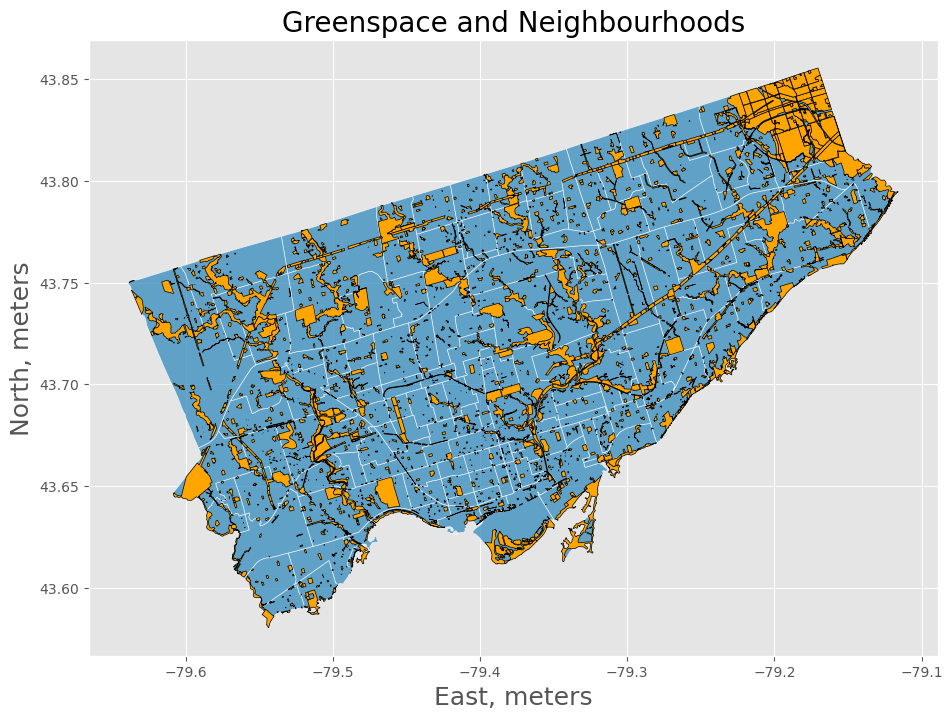

In [ ]:
ax = neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)                       #plot size and colour
greenspace.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains')  
plt.xlabel('East, meters', fontsize=18)                                                    #axses labels
plt.ylabel('North, meters', fontsize=18) 
plt.title('Greenspace and Neighbourhoods', fontsize=20)                          #title
plt.show()

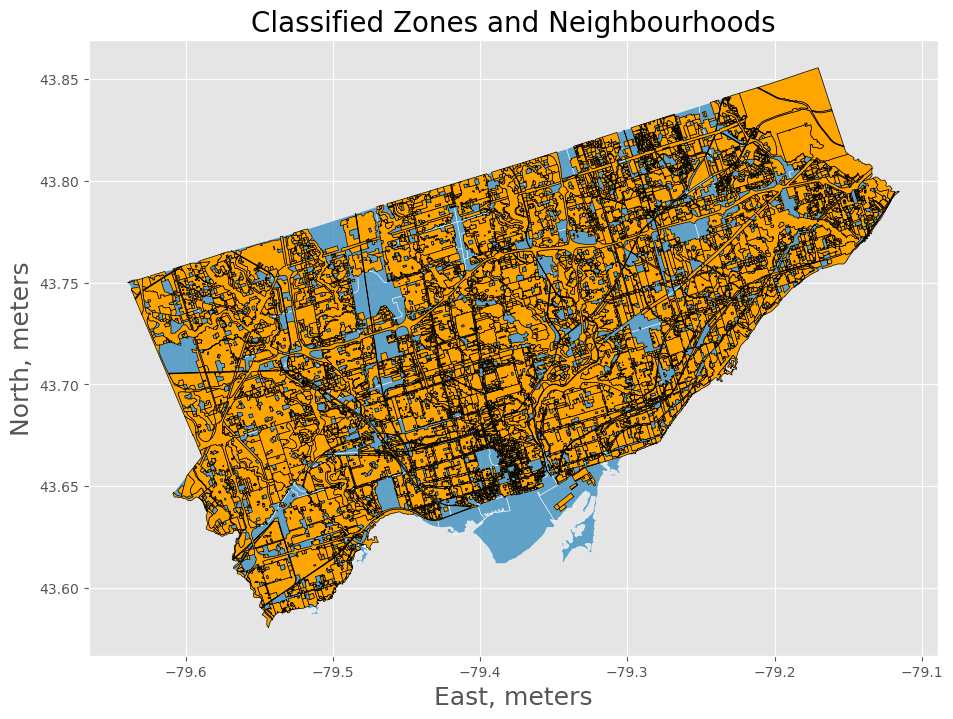

In [ ]:
ax = neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)                       #plot size and colour
zones_geodata.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains')  
plt.xlabel('East, meters', fontsize=18)                                                    #axses labels
plt.ylabel('North, meters', fontsize=18) 
plt.title('Classified Zones and Neighbourhoods', fontsize=20)                          #title
plt.show()

c:\Users\aaron\anaconda3\Lib\site-packages\mapclassify\classifiers.py:462: RuntimeWarning: invalid value encountered in greater
  binIds += (x > _l) * (x <= r) * k
c:\Users\aaron\anaconda3\Lib\site-packages\mapclassify\classifiers.py:462: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > _l) * (x <= r) * k


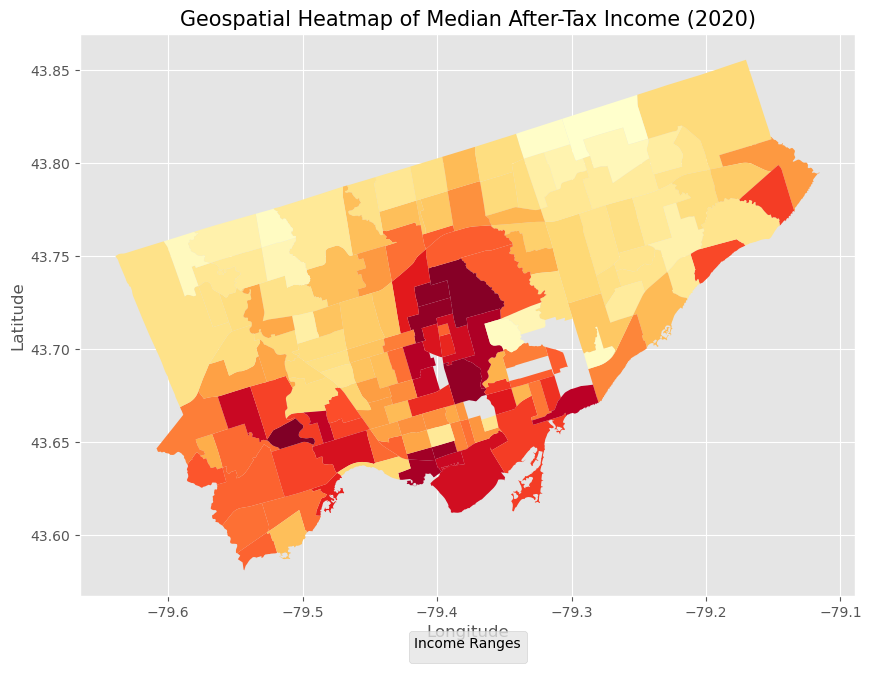

In [ ]:
income_data = neighbourhood_demographics_transpose[["    Median total income in 2020  among recipients ($)"]]
merged_gdf = neighbourhoods_geodata.join(income_data)

classifier = mapclassify.Quantiles(merged_gdf["    Median total income in 2020  among recipients ($)"], k=4)
merged_gdf["income_bins"] = classifier.yb  # Add the classification to the GeoDataFrame


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with the selected income column for color mapping
merged_gdf.plot(column="    Median total income in 2020  among recipients ($)",
                ax=ax,
                cmap='YlOrRd',  # Choose the color map, e.g., 'viridis', 'coolwarm', etc.
                legend_kwds={
                    'label': "Median After-Tax Income ($)",  # Label for the legend
                    'orientation': "horizontal",  # Orientation of the legend
                    'bbox_to_anchor': (0.5, -0.05),  # Position the legend
                    'loc': 'upper center'  # Position legend in the center
                })

# Customize the legend
# Create a list of the bin labels based on the classification
bin_labels = [f"{round(classifier.bins[i], 2)} - {round(classifier.bins[i + 1], 2)}"
              for i in range(len(classifier.bins) - 1)]

# Add a legend with the appropriate bin ranges
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, bin_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Income Ranges")

# Add title and labels
ax.set_title("Geospatial Heatmap of Median After-Tax Income (2020)", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()


Now we shall only retrieve the columns that pertain to the vulnerability index.

Next step is to create a vulnerability index.

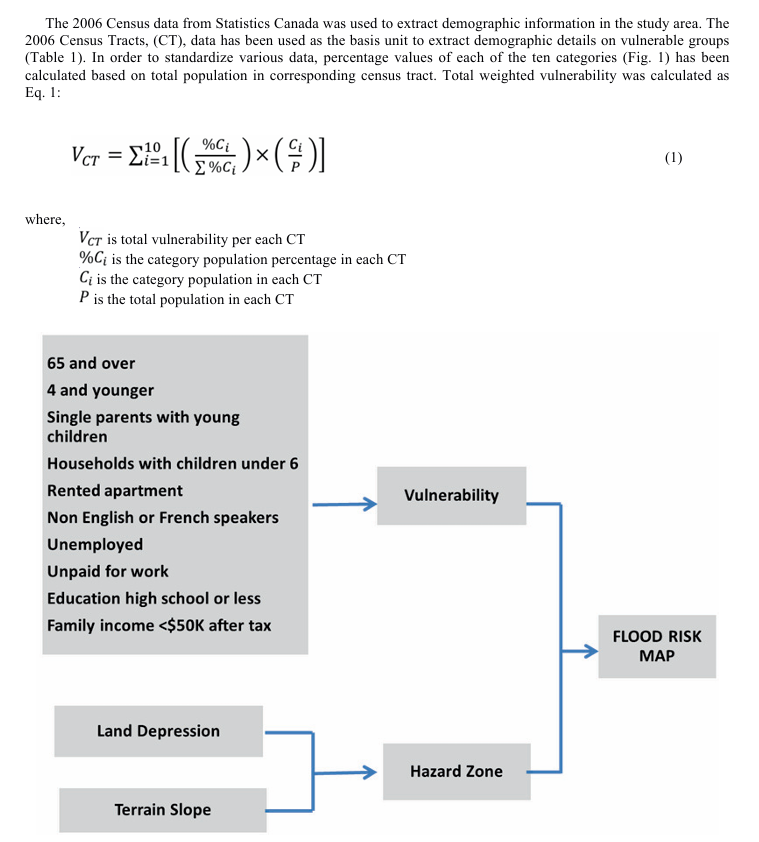

In [ ]:

columns_to_sum = [
    '  Under $5,000 (279)',
    '  $5,000 to $9,999 (280)',
    '  $10,000 to $14,999 (281)',
    '  $15,000 to $19,999 (282)',
    '  $20,000 to $24,999 (283)',
    '  $25,000 to $29,999 (284)',
    '  $30,000 to $34,999 (285)',
    '  $35,000 to $39,999 (286)',
    '  $40,000 to $44,999 (287)',
    '  $45,000 to $49,999 (288)'
]
# Create the new column by summing the specified columns
merged_neighbourhood_df['Family Income under 50k'] = merged_neighbourhood_df[columns_to_sum].sum(axis=1)

columns_to_sum = [
    '  French only (428)',
    '  Neither English nor French (430)',]
# Create the new column by summing the specified columns
merged_neighbourhood_df['Non English or french Speakers'] = merged_neighbourhood_df[columns_to_sum].sum(axis=1)

# Columns with better names
merged_neighbourhood_df['Unemployed'] = merged_neighbourhood_df[['  Without total income (90)']]
merged_neighbourhood_df['Education high school or less'] = merged_neighbourhood_df[['Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data (1980)']]

vul_index_df = merged_neighbourhood_df[[ 
    '  65 years and over (18)',
    '  0 to 14 years (3)', #No data for 4 and younger, so this is the closest column to the data
    '    Parents in one-parent families (38)',
    '    Children (39)', # Data does not specify age of children, so will take populations including children
    '  Renter (300)',
    'Non English or french Speakers',
    'Unemployed',
    '  Gini index on adjusted household total income (211)', # in place for unpaid work to give measure of inequality
    'Family Income under 50k',
    'Education high school or less',
    # These three columns are needed to map the data
    'Neighbourhood Number (0)', 
    'TSNS 2020 Designation (1)', 
    'geometry (2603)',
    'Total - Age groups of the population - 25% sample data (2)' # Total Population
]]

vul_index_df.head()
vul_index_df.shape

(158, 14)

In [ ]:
def calculate_vulnerability_vul_index(data, category_columns, total_population_column):
    """
    Calculate the total vulnerability (V_CT) for each Census Tract (CT) using the vulnerability index DataFrame.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing vulnerability index data.
    - category_columns (list): List of column names for the category populations (C_i).
    - total_population_column (str): Column name for the total population (P) in each CT.
    
    Returns:
    - pd.DataFrame: The original DataFrame with an additional 'V_CT' column for vulnerability scores.
    """
    data = data.copy()
    
    # Step 1: Calculate %C_i for each category across all CTs
    total_category_population = data[category_columns].sum().sum()
    for col in category_columns:
        data.loc[:, f'%{col}'] = data[col] / total_category_population

    # Step 2: Calculate C_i / P for each category in each CT
    for col in category_columns:
        data.loc[:, f'{col}_Ci_P'] = data[col] / data[total_population_column]
    
    # Step 3: Calculate V_CT (weighted vulnerability sum) for each CT
    data['V_CT'] = data.apply(
        lambda row: sum(
            row[f'{col}_Ci_P'] * row[f'%{col}'] for col in category_columns
        ),
        axis=1
    )
    
    return data

# Example usage:
category_columns = [
    '  65 years and over (18)',
    '  0 to 14 years (3)',
    '    Parents in one-parent families (38)',
    '    Children (39)',
    '  Renter (300)',
    'Non English or french Speakers',
    'Unemployed',
    '  Gini index on adjusted household total income (211)',
    'Family Income under 50k',
    'Education high school or less'
]

total_population_column = 'Total - Age groups of the population - 25% sample data (2)'

# Calculate vulnerability
vul_index_df = calculate_vulnerability_vul_index(
    vul_index_df, category_columns, total_population_column
)


In [51]:
vul_index_df.head()

65 years and over (18)  \
West Humber-Clairville                                5360   
Mount Olive-Silverstone-Jamestown                     4170   
Thistletown-Beaumond Heights                          1740   
Rexdale-Kipling                                       1850   
Elms-Old Rexdale                                      1390   

                                    0 to 14 years (3)  \
West Humber-Clairville                           4295   
Mount Olive-Silverstone-Jamestown                5690   
Thistletown-Beaumond Heights                     1495   
Rexdale-Kipling                                  1575   
Elms-Old Rexdale                                 1610   

                                      Parents in one-parent families (38)  \
West Humber-Clairville                                               2080   
Mount Olive-Silverstone-Jamestown                                    2450   
Thistletown-Beaumond Heights                                          660   
Rexdale-Kipling                                                       765   
Elms-Old Rexdale                                                      915   

                                      Children (39)   Renter (300)  \
West Humber-Clairville                        11095           3705   
Mount Olive-Silverstone-Jamestown             12670           5260   
Thistletown-Beaumond Heights                   3475           1220   
Rexdale-Kipling                                3500           1955   
Elms-Old Rexdale                               3685           1430   

                                  Non English or french Speakers Unemployed  \
West Humber-Clairville                                      1340       1445   
Mount Olive-Silverstone-Jamestown                           2305       1665   
Thistletown-Beaumond Heights                                 490        440   
Rexdale-Kipling                                              295        355   
Elms-Old Rexdale                                             345        420   

                                    Gini index on adjusted household total income (211)  \
West Humber-Clairville                                                           0.3      
Mount Olive-Silverstone-Jamestown                                                0.3      
Thistletown-Beaumond Heights                                                     0.3      
Rexdale-Kipling                                                                  0.3      
Elms-Old Rexdale                                                                 0.3      

                                  Family Income under 50k  \
West Humber-Clairville                               2555   
Mount Olive-Silverstone-Jamestown                    2875   
Thistletown-Beaumond Heights                          920   
Rexdale-Kipling                                      1375   
Elms-Old Rexdale                                      830   

                                  Education high school or less  ...  \
West Humber-Clairville                                    29000  ...   
Mount Olive-Silverstone-Jamestown                         25655  ...   
Thistletown-Beaumond Heights                               8350  ...   
Rexdale-Kipling                                            8805  ...   
Elms-Old Rexdale                                           7745  ...   

                                    0 to 14 years (3)_Ci_P  \
West Humber-Clairville                            0.128979   
Mount Olive-Silverstone-Jamestown                 0.181528   
Thistletown-Beaumond Heights                      0.151777   
Rexdale-Kipling                                   0.151807   
Elms-Old Rexdale                                    0.1721   

                                      Parents in one-parent families (38)_Ci_P  \
West Humber-Clairville                                                0.062462   
Mount Olive-Silverstone-Jamestown                                     0.07816

In [52]:
# Check if the required columns exist in flood_df
if 'Neighbourhood_name' in flood_df.columns and 'Proportion Neighbourhood flooded' in flood_df.columns:
    # Merge the Proportion Neighbourhood flooded column into the big DataFrame
    vul_index_df = vul_index_df.merge(
        flood_df[['Neighbourhood_name', 'Proportion Neighbourhood flooded']],
        how='left',
        left_index=True,  # Match based on the index of big_dataframe
        right_on='Neighbourhood_name'  # Match with Neighbourhood_name in flood_df
    )
    # Drop the redundant Neighbourhood_name column from flood_df
    vul_index_df = vul_index_df.drop(columns=['Neighbourhood_name'])
else:
    print("Error: flood_df does not have the required columns.")

# Output the updated big DataFrame
print("vul_index_df with Proportion Neighbourhood flooded column:")
vul_index_df.head()

vul_index_df with Proportion Neighbourhood flooded column:


65 years and over (18)   0 to 14 years (3)  \
35.0                     5360                4295   
21.0                     4170                5690   
2.0                      1740                1495   
44.0                     1850                1575   
0.0                      1390                1610   

         Parents in one-parent families (38)     Children (39)   Renter (300)  \
35.0                                    2080             11095           3705   
21.0                                    2450             12670           5260   
2.0                                      660              3475           1220   
44.0                                     765              3500           1955   
0.0                                      915              3685           1430   

     Non English or french Speakers Unemployed  \
35.0                           1340       1445   
21.0                           2305       1665   
2.0                             490        440   
44.0                            295        355   
0.0                             345        420   

       Gini index on adjusted household total income (211)  \
35.0                                                0.3      
21.0                                                0.3      
2.0                                                 0.3      
44.0                                                0.3      
0.0                                                 0.3      

     Family Income under 50k Education high school or less  ...  \
35.0                    2555                         29000  ...   
21.0                    2875                         25655  ...   
2.0                      920                          8350  ...   
44.0                    1375                          8805  ...   
0.0                      830                          7745  ...   

         Parents in one-parent families (38)_Ci_P     Children (39)_Ci_P  \
35.0                                     0.062462               0.333183   
21.0                                     0.078162               0.404211   
2.0                                      0.067005               0.352792   
44.0                                     0.073735               0.337349   
0.0                                      0.097809               0.393907   

       Renter (300)_Ci_P Non English or french Speakers_Ci_P Unemployed_Ci_P  \
35.0            0.111261                             0.04024        0.043393   
21.0             0.16781                            0.073536        0.053119   
2.0             0.123858                            0.049746         0.04467   
44.0            0.188434                            0.028434        0.034217   
0.0             0.152859                            0.036879        0.044896   

       Gini index on adjusted household total income (211)_Ci_P  \
35.0                                           0.000009           
21.0                                            0.00001           
2.0                                             0.00003           
44.0                                           0.000029           
0.0                                            0.000032           

     Family Income under 50k_Ci_P Education high school or less_Ci_P  \
35.0                     0.076727                           0.870871   
21.0                     0.091721                           0.818472   
2.0                      0.093401                           0.847716   
44.0                      0.13253                           0.848675   
0.0                      0.088723                             0.8279   

          V_CT Proportion Neighbourhood flooded  
35.0  0.005870                         0.082658  
21.0  0.005509                         0.130259  
2.0   0.001723                         0.266341  
44.0  0.001852                         0.073437  
0.0   0.001647                         0.412427  

[5 rows x 36 columns]